In [27]:
import time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def timestamp_to_datetime(timestamp):    
    return datetime.date.fromtimestamp(float(timestamp))
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/go-trader-aTWd7ZB6-py3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Read in data

#
- https://blog.rmotr.com/bitcoin-trading-with-python-bollinger-bands-strategy-analysis-b1a223385a89

In [65]:
data = pd.read_csv("../data/localbtcUSD.csv", names=["datetime", "price", "volume"],
    index_col=0,
    parse_dates=True)

In [66]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3977580 entries, 1363046255 to 1546938874
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   volume  float64
dtypes: float64(2)
memory usage: 91.0 MB


In [75]:
data.index = pd.to_datetime(data.index, unit='s')

In [76]:
data.head()

,price,volume
datetime,,
2013-03-11 23:57:35,72.00,4.9999
2013-03-12 19:36:32,67.79,1.9999
2013-03-13 12:27:52,52.21,14.7684
2013-03-13 17:06:01,56.29,0.6401
2013-03-13 18:01:20,40.00,1.7500


In [77]:
data.tail()

,price,volume
datetime,,
2019-01-08 09:11:30,4057.75,0.024644
2019-01-08 09:12:14,6002.25,0.031655
2019-01-08 09:13:12,4293.61,0.132988
2019-01-08 09:13:44,4517.69,0.006641
2019-01-08 09:14:34,4170.85,0.235444


In [78]:
price_df = data.price.resample("D").ohlc()

### Candles

In [79]:
price_df.head()

,open,high,low,close
datetime,,,,
2013-03-11,72.00,72.00,72.00,72.00
2013-03-12,67.79,67.79,67.79,67.79
2013-03-13,52.21,56.29,40.00,40.00
2013-03-14,70.30,70.30,50.35,50.35
2013-03-15,49.52,70.96,47.75,48.41


## Calculate Bollinger Bands

In [80]:
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 200
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = price_df['close'].rolling(window).mean()
rolling_std = price_df['close'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
price_df['Rolling Mean'] = rolling_mean
price_df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
price_df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

In [81]:
price_df.dropna(inplace=True)

In [82]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1731 entries, 2013-09-26 to 2019-01-08
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            1731 non-null   float64
 1   high            1731 non-null   float64
 2   low             1731 non-null   float64
 3   close           1731 non-null   float64
 4   Rolling Mean    1731 non-null   float64
 5   Bollinger High  1731 non-null   float64
 6   Bollinger Low   1731 non-null   float64
dtypes: float64(7)
memory usage: 108.2 KB


<AxesSubplot:xlabel='datetime'>

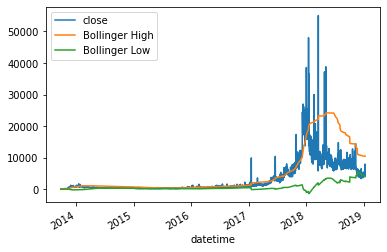

In [83]:
price_df[['close','Bollinger High','Bollinger Low']].plot()


<AxesSubplot:xlabel='datetime'>

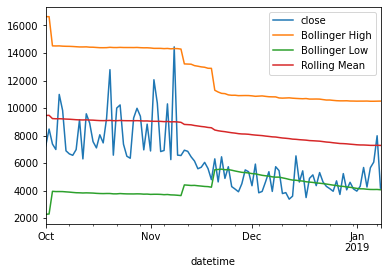

In [84]:
price_df[price_df.index >= '2018-10-01'][['close','Bollinger High','Bollinger Low', 'Rolling Mean']].plot()


## Working on a strategy

In [85]:
# create a new column in the DataFrame to hold positions information
price_df['Position'] = None

# fill our position column based on the following rules:
#     * set to short (-1) when the price hits the upper band
#     * set to long (1) when it hits the lower band       
mode = 'open'
for index in range(len(price_df)):
    if index == 0:
        continue

    row = price_df.iloc[index]
    prev_row = price_df.iloc[index - 1]

    # long?
    if mode == 'open' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = 1
        mode = 'close'

    # short?
    if mode == 'close' and row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = -1
        mode = 'open'

In [86]:
price_df.dropna(subset=['Position'])


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position
datetime,,,,,,,,
2014-12-12,350.40,5000.00,314.75,336.24,578.86855,804.255574,353.481526,1
2015-05-31,248.43,927.64,195.76,511.95,326.14610,450.390794,201.901406,-1
2015-09-30,271.56,2617.80,201.41,203.00,303.63670,398.281866,208.991534,1
2015-10-03,248.57,2617.80,191.87,407.83,302.90670,397.546825,208.266575,-1
2018-11-21,6498.87,35999.95,3433.56,4625.66,8346.60400,11162.258646,5530.949354,1


## Visualize position

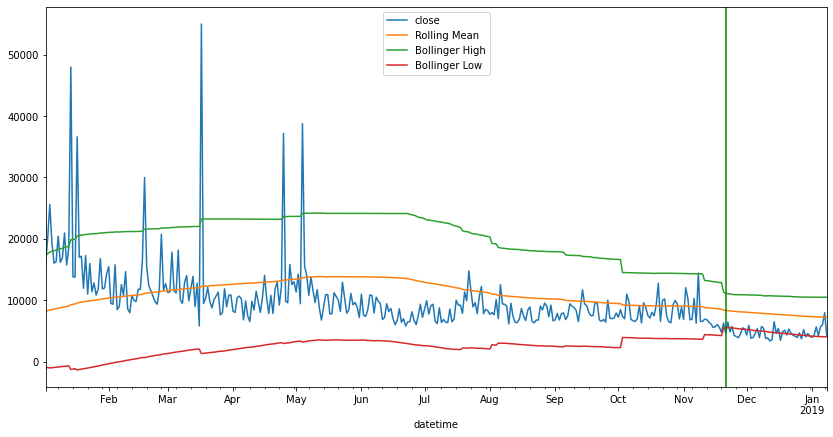

In [87]:

price_df[price_df.index > '2018-01-01'][['close', 'Rolling Mean', 'Bollinger High','Bollinger Low']].plot(figsize=(14, 7))

for index, pos in price_df[price_df.index > '2018-01-01'].dropna(subset=['Position'])['Position'].iteritems():
    plt.axvline(index, color='green' if pos == 1 else 'red')

<AxesSubplot:xlabel='datetime'>

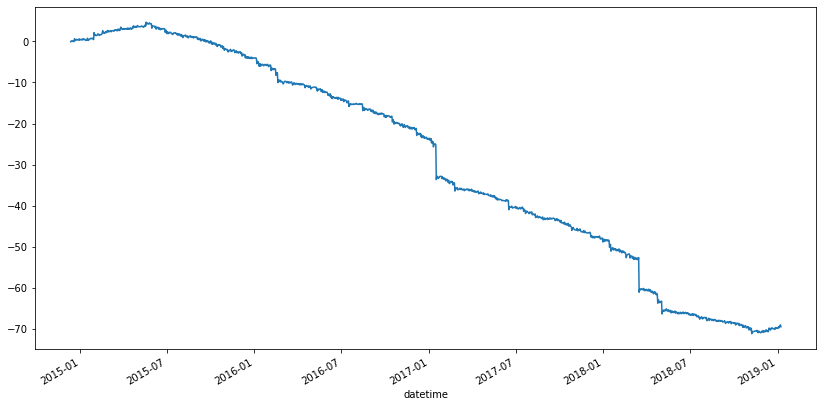

In [88]:
# forward fill our Position column to replace "None" values with the correct buy/sell 
# operations to represent the "holding" of our position forward through time
# price_df.dropna(inplace=True)
price_df['Position'].fillna(method='ffill', inplace=True)

# calculate the daily market return and multiply that by the position to determine strategy returns
price_df['Market Return'] = price_df['close'].pct_change()
price_df['Strategy Return'] = price_df['Market Return'] * price_df['Position']

# plot the strategy returns
price_df['Strategy Return'].cumsum().plot(figsize=(14, 7))

In [89]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2013-09-26,131.95,194.76,98.75,145.11,119.20890,164.312202,74.105598,NaN,NaN,NaN
2013-09-27,148.90,190.11,115.07,129.57,119.49675,164.331286,74.662214,NaN,-0.107091,NaN
2013-09-28,129.81,190.32,101.51,146.22,119.88890,164.471780,75.306020,NaN,0.128502,NaN
2013-09-29,134.18,254.00,114.30,150.18,120.43980,164.316448,76.563152,NaN,0.027082,NaN
2013-09-30,135.19,201.75,118.33,134.82,120.86215,164.123573,77.600727,NaN,-0.102277,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,7299.61170,10505.638173,4093.585227,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,7284.80430,10492.448657,4077.159943,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,7283.01505,10491.970786,4074.059314,1.0,0.072237,0.072237


# Finding a better configuration¶


In [90]:
data.head()

,price,volume
datetime,,
2013-03-11 23:57:35,72.00,4.9999
2013-03-12 19:36:32,67.79,1.9999
2013-03-13 12:27:52,52.21,14.7684
2013-03-13 17:06:01,56.29,0.6401
2013-03-13 18:01:20,40.00,1.7500


In [269]:
class BollingerBandsSimulator:

    def __init__(self, df_original, from_date, period, window, no_of_std, figsize=None):
        self.df = df_original
        self.from_date = from_date
        self.period = period
        self.window = window
        self.no_of_std = no_of_std
        self.figsize = figsize
    
    def _build_candles_dataframe(self):
        self.df = self.df.loc[self.from_date:, ["price"]].copy()
        self.df = self.df["price"].resample(self.period).ohlc()
                
    def _build_bollinger_bands(self):
        rolling_mean = self.df['close'].rolling(self.window).mean()
        rolling_std = self.df['close'].rolling(self.window).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)

    def _calculate_positions(self):
        self.df['Position'] = None
        self.df['Mode'] = None
        self.number_of_trades = 0

        mode = 'no_position'
        
        for index in range(len(self.df)):
            if index == 0:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] =  mode
                continue

            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]
            
            # get out of position if price crosses mean
            # (if mode == 'open' or mode == 'no_position' ) and 

            # open -> no_position? no position is below running mean
            if mode == 'buy'  and row['close'] < row['Rolling Mean']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_no_position'
                self.number_of_trades  +=1
                mode = 'no_position'
            
            # close -> no_position? no position if above running mean
            if mode == 'short'  and row['close'] > row['Rolling Mean']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short_to_no_position'
                self.number_of_trades  +=1
                mode = 'no_position'
            
            # initiate buy
            # if mode == 'no_position' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
            #     self.df.iloc[index, self.df.columns.get_loc('Position')] = 1 # this is our last buy
            #     self.df.iloc[index, self.df.columns.get_loc('Position') + 1] = 0 # this is our sell
            #     self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_out'
            #     self.number_of_trades  +=1
            #     mode = 'no_position'     
            
            # buy
            if mode == 'no_position' and  prev_row['close'] > prev_row['Bollinger Low']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1 # buy
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy'
                self.number_of_trades  +=1
                mode = 'buy'     
        
            # short?
            if mode == 'no_position' and prev_row['close'] > prev_row['Bollinger High']:
                print('')
                self.df.iloc[index, self.df.columns.get_loc('Position')] = -1 #  short
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short'
                self.number_of_trades  +=1
                mode = 'short' 
                       
            else:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = "still_doing_" + mode
        
    def _calculate_returns(self):
        
        self.df['Original Position'] = self.df['Position']
        self.df['Position'].fillna(method='ffill', inplace=True)
        self.df['Market Return'] = self.df['close'].pct_change()
        self.df['Strategy Return'] = self.df['Market Return'] * self.df['Position']

    def _plot_returns(self):
        self.df['Strategy Return'].cumsum().plot(figsize=self.figsize)
        

    def simulate(self):
        self._build_candles_dataframe()
        self._build_bollinger_bands()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()

        return (
            self.period, 
            self.window, 
            self.no_of_std, 
            self.df['Strategy Return'].sum(),
            self.number_of_trades
        )

('24H', 90, 1.5, 32.495303074934796, 593)

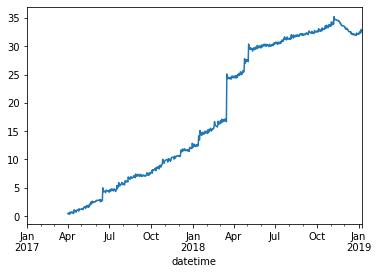

In [270]:

simulator = BollingerBandsSimulator(
    data, 
    from_date="2017-01-01", 
    period="24H", 
    window=90, 
    no_of_std=1.5
)
simulator.simulate()

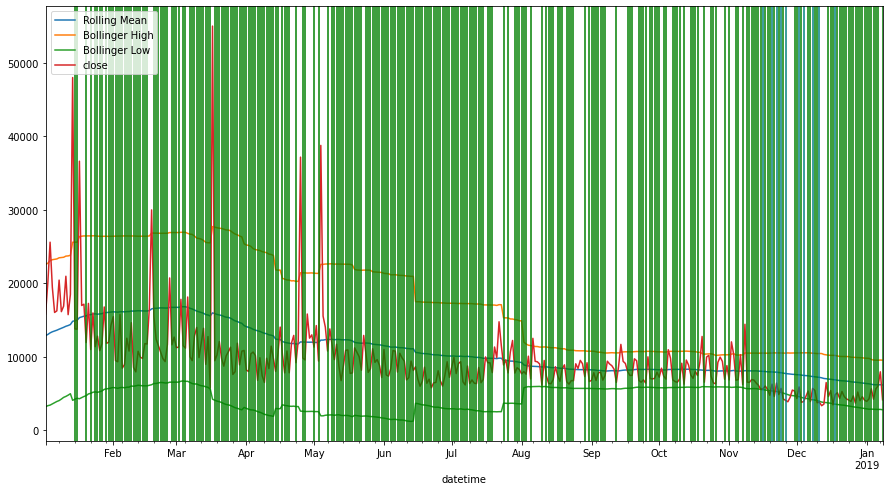

In [271]:
DATE_FILTER = '2018-01-01'
simulator.df[simulator.df.index > DATE_FILTER ]  [['Rolling Mean', 'Bollinger High', 'Bollinger Low', 'close']].plot(figsize=(15,8))

prev_pos = None
for index, pos in simulator.df[simulator.df.index > DATE_FILTER ]['Original Position'].iteritems():
    if pos == -1:
        plt.axvline(index, color='red')
    if pos == 1:
        plt.axvline(index, color='green')
    if pos == 0:
        plt.axvline(index, color='teal')


In [272]:
simulator.df[simulator.df.index > "2018-10-20"].head(25)

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Mode,Original Position,Market Return,Strategy Return
datetime,,,,,,,,,,,,
2018-10-21,9860.00,51559.95,4541.47,6571.57,8165.905556,10378.097721,5953.713390,1.0,still_doing_buy,1,-0.486114,-0.486114
2018-10-22,6600.00,51247.60,4812.76,9996.00,8177.983222,10406.025862,5949.940583,1.0,still_doing_buy,None,0.521098,0.521098
2018-10-23,6409.71,70435.43,4481.46,10223.57,8184.730000,10424.719311,5944.740689,1.0,still_doing_buy,None,0.022766,0.022766
2018-10-24,9182.10,64998.38,4487.69,7368.66,8179.561111,10422.598187,5936.524035,1.0,still_doing_buy,1,-0.279248,-0.279248
2018-10-25,6895.09,70303.71,5011.76,6493.19,8133.153444,10356.085267,5910.221622,1.0,still_doing_buy,1,-0.118810,-0.118810
2018-10-26,9592.69,25672.03,4666.67,6347.28,8067.615222,10208.806820,5926.423625,1.0,still_doing_buy,1,-0.022471,-0.022471
2018-10-27,5945.49,51232.40,4666.14,9272.83,8083.896667,10233.108009,5934.685324,1.0,still_doing_buy,None,0.460914,0.460914
2018-10-28,9415.00,64998.38,4840.71,9980.55,8099.958333,10268.902945,5931.013722,1.0,still_doing_buy,None,0.076322,0.076322
2018-10-29,7059.57,50191.73,4765.88,9396.60,8112.200444,10290.622844,5933.778045,1.0,still_doing_buy,None,-0.058509,-0.058509


In [273]:
simulator.df[simulator.df.index > "2018-04-20"]['Mode'].value_counts()

still_doing_buy            246
still_doing_no_position     17
Name: Mode, dtype: int64

# Brute force some configurations¶


In [19]:
 # generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
# for example the first one creates a vector of 5 evenly spaced integer values ranging from 10 to 100
windows = np.linspace(7, 90, 8, dtype=int)
stds = np.linspace(1.5, 2, 2)
periods = np.linspace(15 ,240, 6, dtype=int)

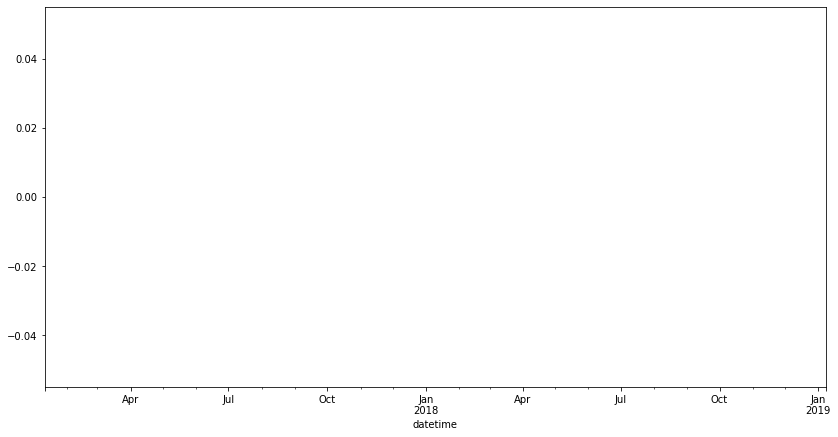

In [20]:
# iterate through them, running the strategy function each time and collecting returns
# (this might take some time)
simulations = []
result_df = pd.DataFrame({
    'period': [], 
    'window': [],
    'no_of_std': [],
    'result': []
})
for window in windows:
    for std in stds:
        for period in periods:
            simulator = BollingerBandsSimulator(
                data, 
                from_date="2017-01-11", 
                period="{}min".format(period), 
                window=window, 
                no_of_std=std,
                figsize=(14, 7)
            )
            period, window, no_of_std, result, total_trades = simulator.simulate()
            result_df = result_df.append({
                'period': period, 
                'window': window, 
                'no_of_std': no_of_std, 
                'result': result,
                'total_trades': total_trades
            }, ignore_index=True)
            simulations.append(simulator)

In [23]:
result_df.sort_values(by='result').tail(15) # Hours results in 1-2 trades. Test minutes

,period,window,no_of_std,result,total_trades
37,60min,42.0,1.5,0.0,0.0
36,15min,42.0,1.5,0.0,0.0
35,240min,30.0,2.0,0.0,0.0
34,195min,30.0,2.0,0.0,0.0
33,150min,30.0,2.0,0.0,0.0
32,105min,30.0,2.0,0.0,0.0
31,60min,30.0,2.0,0.0,0.0
30,15min,30.0,2.0,0.0,0.0
29,240min,30.0,1.5,0.0,0.0
28,195min,30.0,1.5,0.0,0.0


In [22]:
result_df.sort_values(by='result').tail(15).mean()

/var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/ipykernel_85509/3784085997.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_df.sort_values(by='result').tail(15).mean()


window          39.600000
no_of_std        1.766667
result           0.000000
total_trades     0.000000
dtype: float64

In [ ]:
WINNING_STRATEGY_INDEX = 30

### Look at the trading pattern for a winning strategy

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum()

datetime
2018-01-11 00:00:00         NaN
2018-01-11 06:40:00         NaN
2018-01-11 13:20:00         NaN
2018-01-11 20:00:00         NaN
2018-01-12 02:40:00         NaN
                         ...   
2019-01-07 02:40:00    2.798846
2019-01-07 09:20:00    3.080088
2019-01-07 16:00:00    3.041177
2019-01-07 22:40:00    3.071222
2019-01-08 05:20:00    3.091579
Freq: 400T, Name: Strategy Return, Length: 1305, dtype: float64

<AxesSubplot:xlabel='datetime'>

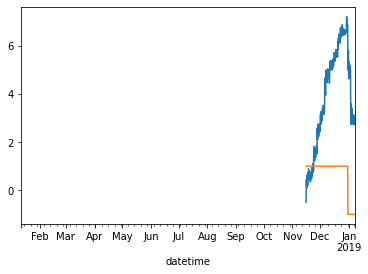

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum().plot()
simulations[WINNING_STRATEGY_INDEX].df['Position'].plot()

<AxesSubplot:xlabel='datetime'>

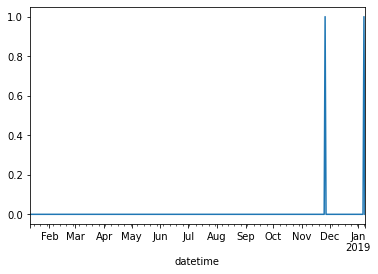

In [162]:
simulations[WINNING_STRATEGY_INDEX].df['Number of Trades'].plot()